<a href="https://colab.research.google.com/github/tiashamondal29/Global-Wheat-Detection-Faster-R-CNN-and-DETR/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with PyTorch and Faster R-CNN

**Author:** Tiasha Mondal (Registration Number: 202259828)


**Objective:** In this notebook, we will create a object detection model using [**Faster R-CNN architecture**](https://arxiv.org/abs/1506.01497) with [PyTorch](https://pytorch.org/). 

Faster R-CNN is a state-of-the-art object detection algorithm that uses a region proposal network to efficiently detect objects in images. We will **download a pretrained model** for the training procedure. This notebook will provide an in-depth analysis of the models' accuracy, precision, recall and mean average precision (mAP) on the dataset, https://www.kaggle.com/competitions/global-wheat-detection/data


# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import shutil
import torch
from PIL import Image, ImageDraw
import torch.nn as nn
from skimage import io
import os
import torchvision
import time
import cv2
import random
import gc
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
! pip install albumentations==0.4.6 
from google.colab.patches import cv2_imshow
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo
import albumentations                                                                             
from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T
#from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached albumentations-0.4.6-py3-none-any.whl
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-pyx0mgfw



**Loading the Dataset from the kaggle**

Upload kaggle.json from your respective kaggle account

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c global-wheat-detection

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 607M/607M [00:28<00:00, 20.3MB/s]
100% 607M/607M [00:28<00:00, 22.6MB/s]


In [ ]:
# Directory setting
zip_file = "/content/global-wheat-detection.zip"
DATA_DIR = '/content/global-wheat-detection/'
MODEL_DIR = '/content/output/'
IMG_SAVE_DIR = '/content/output/'

# Helper Functions

In [ ]:
def load_img(path):
    print(path)
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb
    
def group_bboxes(df):
    df_ = df.copy()
    df_['bbox_count'] = 1
    df_ = df_.groupby(['image_id', 'source']).count().reset_index()
    return_df = df_[['image_id', 'source', 'bbox_count']]
    return return_df


def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/
    
    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """    
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result

In [ ]:
import zipfile
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

In [ ]:
csv_path = DATA_DIR+'train.csv'
train_dir = DATA_DIR+'train'

**Understanding the Data**

In [ ]:
df = pd.read_csv(csv_path)
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [ ]:
print(f'Total number of train images is {len(os.listdir(train_dir))}')
print(f'shape of dataframe is {df.shape}')
print(f'Number of images in dataframe is {len(np.unique(df["image_id"]))}')
print(f'Number of train images with no bounding boxes {len(os.listdir(train_dir)) - len(np.unique(df["image_id"]))}')
unique_img = df.image_id.unique()

Total number of train images is 3422
shape of dataframe is (147793, 5)
Number of images in dataframe is 3373
Number of train images with no bounding boxes 49


In [ ]:
# this function will take the dataframe and vertically stack the image ids 
# with no bounding boxes
def process_bbox(df):
    df['bbox'] = df['bbox'].apply(lambda x: eval(x))
    df['x'] = df['bbox'].apply(lambda x: x[0])
    df['y'] = df['bbox'].apply(lambda x: x[1])
    df['w'] = df['bbox'].apply(lambda x: x[2])
    df['h'] = df['bbox'].apply(lambda x: x[3])
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)

    df.drop(columns=['bbox'],inplace=True)
#     df.reset_index(drop=True)
    return df

In [ ]:
df_new = process_bbox(df)
print(f'shape of dataframe after prerpocessing {df_new.shape}')
df_new.tail()

shape of dataframe after prerpocessing (147793, 8)


<ipython-input-39-fcf80346a1af>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['x'] = df['x'].astype(np.float)
<ipython-input-39-fcf80346a1af>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['y'] = df['y'].astype(np.float)
<ipython-input-39-fcf80346a1af>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `f

image_id  width  height     source      x      y      w     h
147788  5e0747034   1024    1024  arvalis_2   64.0  619.0   84.0  95.0
147789  5e0747034   1024    1024  arvalis_2  292.0  549.0  107.0  82.0
147790  5e0747034   1024    1024  arvalis_2  134.0  228.0  141.0  71.0
147791  5e0747034   1024    1024  arvalis_2  430.0   13.0  184.0  79.0
147792  5e0747034   1024    1024  arvalis_2  875.0  740.0   94.0  61.0

Next, let's restructure the data to have **one image per row**, with the number of bounding boxes in each image. This will make it easier to work with the data and feed it into the model.

In [ ]:
grouped_df = group_bboxes(df_new)
NUM_QUERIES = max(grouped_df['bbox_count']) # How many bboxes shall the model output per image.
grouped_df.head()

image_id     source  bbox_count
0  00333207f  arvalis_1          55
1  005b0d8bb    usask_1          20
2  006a994f7    inrae_1          25
3  00764ad5d    inrae_1          41
4  00b5fefed  arvalis_3          25

# Set Configs

In [ ]:
RUN_EDA = True
RUN_TRAINING = True
TRAIN_ALL = False # If true, train with all data and output a single model. If False, run cross-validation and output multiple models.


# Exploratory Data Analysis (EDA)

EDA for images is typically simpler than for tabular data.

**Set `RUN_EDA = True` in the `Set Config` section.**

## Inspect Representative Images

Visually inspecting images is crucial. If the images are noisy or weird, preprocessing may be required before training a model.



/content/global-wheat-detection/train/39a0e5556.jpg
39a0e5556.jpg
/content/global-wheat-detection/train/b838eaf1d.jpg
b838eaf1d.jpg
/content/global-wheat-detection/train/83bfee8fd.jpg
83bfee8fd.jpg
/content/global-wheat-detection/train/daab3de13.jpg
daab3de13.jpg
/content/global-wheat-detection/train/20c6725f1.jpg
20c6725f1.jpg
/content/global-wheat-detection/train/f91e92fd4.jpg
f91e92fd4.jpg


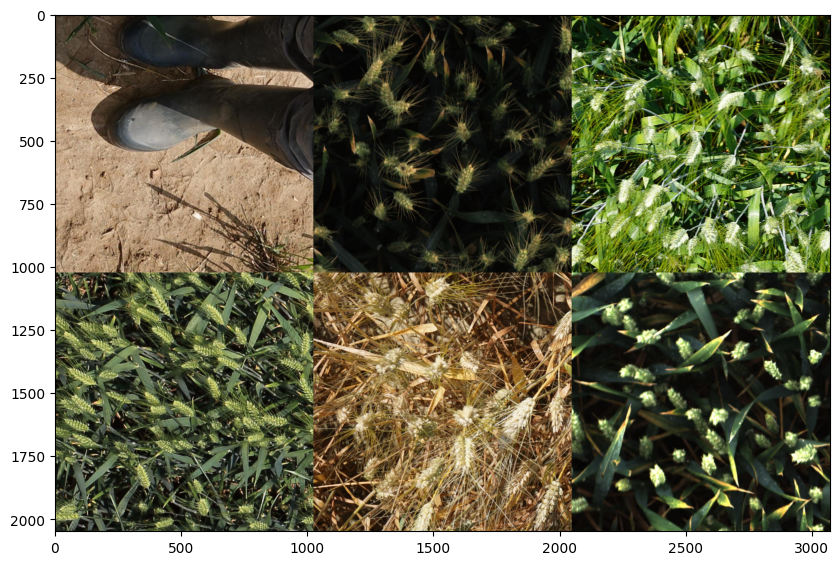

In [ ]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train/').glob('*.jpg')
    img_list = []
    for i, img_name in enumerate(img_names):
        img_list.append(load_img(img_name.as_posix()))
        print(img_name.name)
        if i == 5: 
            break
    plt.figure(figsize=(10,10))
    plt.imshow(create_gallery(np.array(img_list), ncols=3))
else:
    print('RUN_EDA is False')

## Check Image Shape

It is also important to check the size and color of the images in the dataset.

Creating histograms can also be helpful.

In [ ]:
if RUN_EDA:
    img_shape = set()
    img_ext = set()
    img_names = Path(DATA_DIR+'train/').glob('*')
    pbar = tqdm(img_names, total=len(list(grouped_df)))
    pbar.set_description('Processing images')
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        img_shape.add(img.shape)
        img_ext.add(img_name.suffix)
    print(f'Image shapes are {img_shape}.')
    print(f'Image extensions are {img_ext}.')

## Plot histogram of pixel values

Creating a histogram of pixel values can help identify any outlier images (such as those with all zeros).

In [ ]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train/').glob('*')
    plt.figure(figsize=(10,10))
    pbar = tqdm(img_names, total=len(df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        plt.plot(hist)
    plt.show()
else:
    print('RUN_EDA is False')

The image signals in many images appear dark, while in some images they are saturated.

In this notebook, for sake of simplicity, we will proceed to the next section without any preprocessing.

**Splitting to train and validation data**

In [ ]:
image_ids = df_new['image_id'].unique()
train_ids = image_ids[0:int(0.7*len(image_ids))]
val_ids = image_ids[int(0.8*len(image_ids)):]
print(f'Total images {len(image_ids)}')
print(f'No of train images {len(train_ids)}')
print(f'No of validation images {len(val_ids)}')

Total images 3373
No of train images 2361
No of validation images 675


In [ ]:
train_df = df_new[df_new['image_id'].isin(train_ids)]
val_df = df_new[df_new['image_id'].isin(val_ids)]


In [ ]:
val_df.head()

image_id  width  height     source      x      y      w      h
122577  33ea56e1c   1024    1024  arvalis_3    0.0  248.0   69.0   84.0
122578  33ea56e1c   1024    1024  arvalis_3  142.0  458.0  111.0  106.0
122579  33ea56e1c   1024    1024  arvalis_3  568.0  517.0   92.0  117.0
122580  33ea56e1c   1024    1024  arvalis_3  501.0   53.0   85.0  108.0
122581  33ea56e1c   1024    1024  arvalis_3    0.0  532.0    2.0  128.0

# Define Image Transformation and Augmentation

In [ ]:
#returns a list of transforms to be applied to images and labels for training or validation.
#The transforms include flipping the image horizontally or vertically and converting the image to a Tensor.

def get_transforms(phase):
            list_transforms = []
            if phase == 'train':
                list_transforms.extend([
                       Flip(p=0.5)
                         ])
            list_transforms.extend(
                    [
            ToTensorV2(),
                    ])
            list_trfms = Compose(list_transforms,
                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
            return list_trfms

# Define the Dataset

In [ ]:
class Wheatset(Dataset):
    def __init__(self,data_frame,image_dir,phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id'].unique()
        self.transforms = get_transforms(phase)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx] + '.jpg'
#         image_arr = io.imread(os.path.join(self.image_dir,image))
        
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0
        image_id = str(image.split('.')[0])
        point = self.df[self.df['image_id'] == image_id]
        boxes = point[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((point.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id

In [ ]:
train_data = Wheatset(train_df,train_dir,phase='train')
val_data = Wheatset(val_df,train_dir,phase='validation')

print(f'Length of train data {len(train_data)}')
print(f'Length of validation data {len(val_data)}')

Length of train data 2361
Length of validation data 675


# Define the DataLoader

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

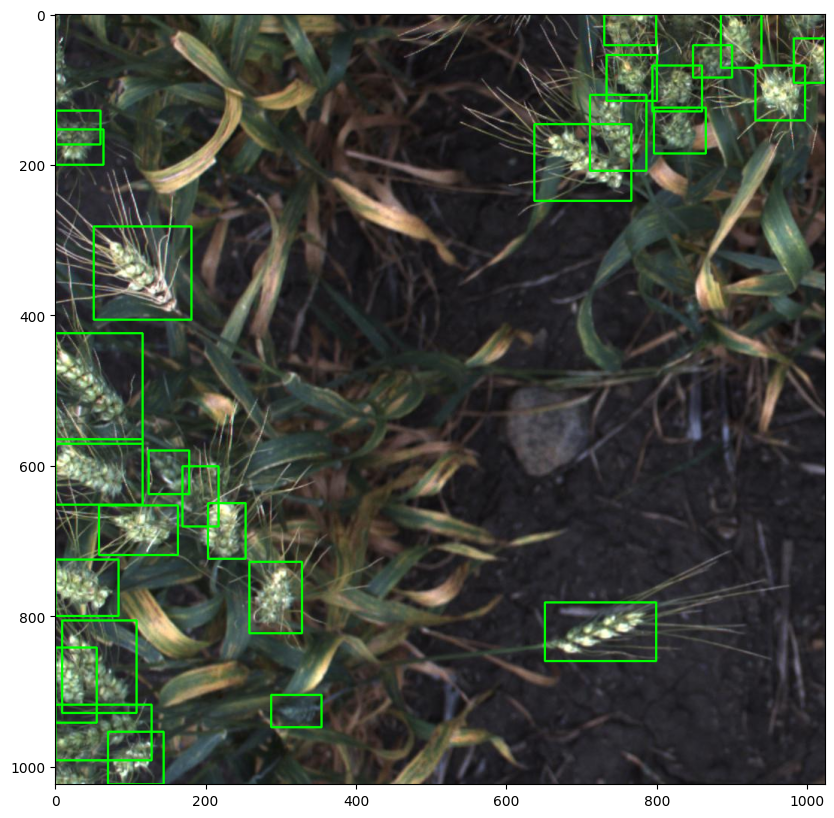

In [ ]:
plot_img(train_data,12)

# Define the Model

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

# Training and Validation

In [ ]:
num_epochs = 5
train_loss_min = 0.9
total_train_loss = []
total_valid_loss = []
valid_loss_min = np.Inf
for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    valid_loss = []
    model.train()
    pbar = tqdm(enumerate(train_data_loader), total=len(train_data_loader))
    for step, (images, targets, image_ids) in pbar:
        
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())
      train_loss.append(losses.item())        
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')
    

    pbar = tqdm(enumerate(valid_data_loader), total=len(valid_data_loader))
    # model.eval()
    with torch.no_grad():
      for step, (images, targets, image_ids) in pbar:
              
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
              
        loss_dict = model(images, targets)
              
        losses = sum(loss for loss in loss_dict.values())
        valid_loss.append(losses.item())
      
      epoch_valid_loss = np.mean(valid_loss)
      total_valid_loss.append(epoch_valid_loss)
      print(f'Epoch validation loss is {epoch_valid_loss}')
      
      # create checkpoint variable and add important data
      checkpoint = {
              'epoch': epoch + 1,
              'train_loss_min': epoch_train_loss,
              'valid_loss_min': epoch_valid_loss,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
          }
    
    # save checkpoint
    # save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_valid_loss))
            # save checkpoint as best model
            # save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_valid_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch :1


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/296 [00:00<?, ?it/s]

Epoch train loss is 0.8666459510430607


  0%|          | 0/85 [00:00<?, ?it/s]

Epoch validation loss is 0.8808411907450798
Validation loss decreased (inf --> 0.880841).  Saving model ...
9m 11s
Epoch :2


  0%|          | 0/296 [00:00<?, ?it/s]

Epoch train loss is 0.8413991019061406


  0%|          | 0/85 [00:00<?, ?it/s]

Epoch validation loss is 0.8458440180638913
Validation loss decreased (0.880841 --> 0.845844).  Saving model ...
9m 13s
Epoch :3


  0%|          | 0/296 [00:00<?, ?it/s]

Epoch train loss is 0.824450593259992


  0%|          | 0/85 [00:00<?, ?it/s]

Epoch validation loss is 0.8423928554384842
Validation loss decreased (0.845844 --> 0.842393).  Saving model ...
9m 13s
Epoch :4


  0%|          | 0/296 [00:00<?, ?it/s]

Epoch train loss is 0.811474043346818


  0%|          | 0/85 [00:00<?, ?it/s]

Epoch validation loss is 0.8348773094162943
Validation loss decreased (0.842393 --> 0.834877).  Saving model ...
9m 19s
Epoch :5


  0%|          | 0/296 [00:00<?, ?it/s]

Epoch train loss is 0.7990148716756498


  0%|          | 0/85 [00:00<?, ?it/s]

Epoch validation loss is 0.8273038425820521
Validation loss decreased (0.834877 --> 0.827304).  Saving model ...
9m 17s


In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    torch.save(model.state_dict(), MODEL_DIR +'fasterrcnn_resnet50_fpn.pth')

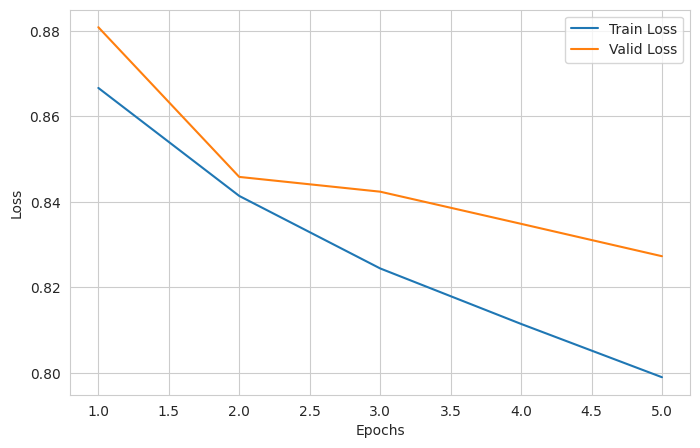

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_valid_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#**Predicting Test Images**

In [ ]:
test_df_path = DATA_DIR+'sample_submission.csv/'
DATASET_DIR = DATA_DIR+'test/'
WEIGHTS_FILE = MODEL_DIR +'fasterrcnn_resnet50_fpn.pth'

In [ ]:
import torchvision.ops as ops

def draw_bbox(image_path, model, device, threshold):
    # Load the image
    data = Image.open(image_path)

    # Apply transformation and run through the model
    transform = T.ToTensor()
    img = transform(data)
    output = model([img.to(device)])

    # Extract bounding boxes and scores
    bbox = output[0]["boxes"]
    scores = output[0]["scores"]

    # Apply non-maximum suppression
    keep = ops.nms(bbox, scores, threshold)

    # Convert the image to numpy array
    im_result = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

    # Create PIL Image from numpy array
    samples = Image.fromarray(im_result)

    # Create a draw object
    draw = ImageDraw.Draw(samples)

    # Draw bounding boxes
    for i in bbox[keep]:
        draw.rectangle(list(i), fill=None, outline="red")

    # Return the modified image
    return samples


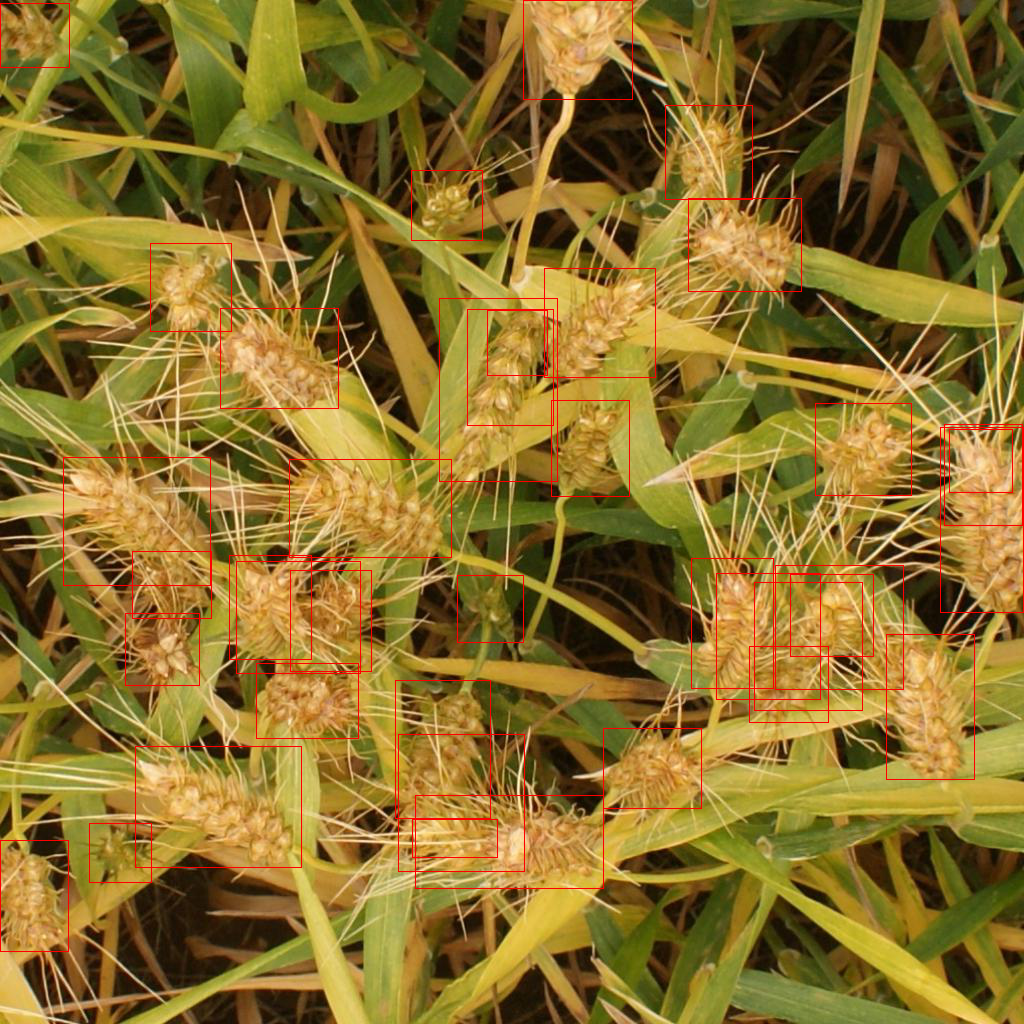

In [ ]:
#Testing one image from test directory
img_path = DATASET_DIR + "f5a1f0358.jpg"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model
threshold = 0.5

result_image = draw_bbox(img_path, model, device, threshold)
result_image.show()


#**Evaluation Matrics - MAP**

In [ ]:
# Create the model architecture
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2  # 1 class (implant) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight en

In [ ]:
dataframe = pd.read_csv(DATA_DIR+'train.csv')
print(dataframe.head())
image_ids = dataframe['image_id'].unique()
val_ids = image_ids[int(0.99*len(image_ids)):]
test_df = dataframe[dataframe['image_id'].isin(val_ids)]
test_df = test_df.reset_index(drop=True)
print(f'Number of images in test dataframe is {len(np.unique(test_df["image_id"]))}')

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1
Number of images in test dataframe is 34


In [ ]:
test_df.head(10)

image_id  width  height                         bbox     source
0  72c3714bc   1024    1024    [384.0, 15.0, 94.0, 72.0]  arvalis_2
1  72c3714bc   1024    1024  [64.0, 645.0, 125.0, 130.0]  arvalis_2
2  72c3714bc   1024    1024  [622.0, 632.0, 92.0, 112.0]  arvalis_2
3  72c3714bc   1024    1024   [458.0, 778.0, 94.0, 97.0]  arvalis_2
4  72c3714bc   1024    1024   [826.0, 317.0, 75.0, 56.0]  arvalis_2
5  72c3714bc   1024    1024   [99.0, 281.0, 116.0, 95.0]  arvalis_2
6  72c3714bc   1024    1024  [540.0, 496.0, 110.0, 82.0]  arvalis_2
7  72c3714bc   1024    1024  [780.0, 657.0, 103.0, 77.0]  arvalis_2
8  72c3714bc   1024    1024   [258.0, 869.0, 87.0, 92.0]  arvalis_2
9  72c3714bc   1024    1024   [399.0, 929.0, 89.0, 95.0]  arvalis_2

In [ ]:
# Extract the dataframe with unique image_id values
test_df = test_df.drop_duplicates(subset=['image_id'], keep='first')
test_df = test_df.reset_index(drop=True)
print(test_df.shape)
test_df.head()

(34, 5)


image_id  width  height                          bbox     source
0  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2
1  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2
2  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2
3  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2
4  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2

In [ ]:
def format_prediction_string(boxes, scores):
    scores = scores.astype(float)
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [ ]:
#Defining the IoU Function for calculating MAP
def IoU(actual_implant, predicted_implant):
  
  actual_implant_area = (actual_implant[2] - actual_implant[0] + 1) * (actual_implant[3] - actual_implant[1] + 1)
  predicted_implant_area = (predicted_implant[2] - predicted_implant[0] + 1) * (predicted_implant[3] - predicted_implant[1] + 1)

  # coordinates of the intersection rectangle
  inter_rect = (max(actual_implant[0], predicted_implant[0]),
                max(actual_implant[1], predicted_implant[1]),
                min(actual_implant[2], predicted_implant[2]),
                min(actual_implant[3], predicted_implant[3])
                )
  
  if (inter_rect[0] >  inter_rect[2] or inter_rect[1] >  inter_rect[3]):
    # No intersection is found, IoU = 0 
    return 0

  inter_rect_area = (inter_rect[2] - inter_rect[0] + 1) * (inter_rect[3] - inter_rect[1] + 1)

  iou = inter_rect_area/float(actual_implant_area + predicted_implant_area - inter_rect_area)

  return float("{:.3f}".format(iou))




In [ ]:
class Implant(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:

def get_test_transform():
    return albumentations.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = Implant(test_df, train_dir, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
# Make predictions on the validation data
start_time = time.time()
detection_threshold = 0.5
results = []
iou_column = []
thresholds_list = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):
        actual_boxes = list(test_df[test_df['image_id'] == image_ids[i]].iloc[0])[3]
        print("ACTUAL_boxes------------------",actual_boxes)

        pred_boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        
        pred_boxes = pred_boxes[scores >= detection_threshold].astype(np.int32)

          
        scores = scores[scores >= detection_threshold]
          

        image_id = image_ids[i]
        
        pred_boxes[:, 2] = pred_boxes[:, 2] - pred_boxes[:, 0]
        pred_boxes[:, 3] = pred_boxes[:, 3] - pred_boxes[:, 1]
       
        result =  format_prediction_string(pred_boxes, scores)

        actual_boxes = np.array([int(float(x.replace('[','').replace(']','').rstrip(','))) for x in actual_boxes.split()[:]], dtype=np.int32)


        # actual_boxes = np.array([int(float(x)) for x in actual_boxes.split()[:]], dtype=np.int32)
        print("ACTUAL_boxes------------------",actual_boxes)
        actual_boxes[2:] = actual_boxes[2]+actual_boxes[0], actual_boxes[3]+actual_boxes[1]
        actual_boxes = np.array(actual_boxes, dtype=np.int32)

       

        
        pred_boxes = pred_boxes[0]
        pred_boxes[2:] = pred_boxes[2]+pred_boxes[0], pred_boxes[3]+pred_boxes[1]


        print("Prediction_boxes------------------",actual_boxes)
        print(scores)
        

        iou = IoU(actual_boxes, pred_boxes)

        thresholds = np.arange(start=0.0, stop=1.01, step=0.05)

        for threshold, theList in zip(thresholds,thresholds_list):
          detection = 'TP' if iou >= threshold else "FP"
          detection = 'FN' if iou ==0 else detection
          theList.append(detection)
        

        iou_column.append(iou)
        results.append(result)

print("Running Time: {}s".format(time.time()-start_time))

In [ ]:
print(len(thresholds_list))
print(len(thresholds))

21
21


In [ ]:
test_df.head()

image_id  width  height                          bbox     source
0  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2
1  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2
2  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2
3  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2
4  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2

In [ ]:
print(results)
print(len(results))
print(len(test_df.index))
results = [prediction for prediction in results if prediction is not None]
test_df['prediction'] = results
test_df['IoU'] = iou_column
# test_df['Detection'] = detection_column

for index, threshold in enumerate(thresholds):
  test_df["{:.2f}".format(threshold)] = thresholds_list[index]

test_df.head()


['0.9832 68 641 107 111 0.9769 400 931 89 87 0.9750 460 785 98 90 0.9726 622 645 84 102 0.9668 257 872 74 83 0.9573 782 674 102 64 0.9532 732 791 101 101 0.9409 444 697 78 69 0.9402 827 321 77 61 0.9383 542 509 88 66 0.9362 764 170 67 64 0.9335 103 290 98 77 0.9243 389 30 91 65 0.9243 357 91 64 71 0.9170 4 175 86 66 0.9148 409 499 85 73 0.9066 232 49 81 72 0.9055 768 64 78 62 0.8803 1 952 72 66 0.8748 247 174 86 75 0.8570 570 268 71 65 0.8237 117 456 78 64 0.8062 466 225 95 56 0.7856 642 767 84 95 0.7826 795 395 74 51 0.7633 851 758 73 111 0.7413 279 693 114 70 0.7143 179 300 160 106 0.7053 261 642 132 120 0.6860 626 386 70 70 0.6658 848 863 116 51 0.5991 503 767 82 70 0.5854 679 989 152 35 0.5603 385 286 54 53', '0.9738 197 736 84 83 0.9669 352 610 96 111 0.9667 338 328 137 79 0.9585 542 348 123 81 0.9569 11 463 61 93 0.9539 438 706 124 128 0.9517 482 467 93 74 0.9417 300 147 91 74 0.9089 537 889 102 107 0.9032 360 520 94 70 0.9003 870 557 75 65 0.8934 406 866 72 105 0.8909 359 93 87 

image_id  width  height                          bbox     source  \
0  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2   
1  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2   
2  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2   
3  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2   
4  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2   

                                          prediction    IoU 0.00 0.05 0.10  \
0  0.9832 68 641 107 111 0.9769 400 931 89 87 0.9...  0.000   FN   FN   FN   
1  0.9738 197 736 84 83 0.9669 352 610 96 111 0.9...  0.000   FN   FN   FN   
2  0.9818 913 835 110 116 0.9737 853 622 91 71 0....  0.000   FN   FN   FN   
3  0.9659 427 0 109 73 0.9391 629 688 119 132 0.9...  0.000   FN   FN   FN   
4  0.9485 535 163 68 99 0.9460 398 960 81 62 0.91...  0.038   TP   FP   FP   

   ... 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95 1.00  
0  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  
1  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  
2  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  
3  ...   FN   FN   FN   FN   FN   FN   FN   FN   FN   FN  
4  ...   FP   FP   FP   FP   FP   FP   FP   FP   FP   FP  

[5 rows x 28 columns]

In [ ]:
test_df['prediction'] = test_df['prediction'].apply(lambda x: ' '.join(x.split()[:5]))


In [ ]:
test_df.head()

image_id  width  height                          bbox     source  \
0  72c3714bc   1024    1024     [384.0, 15.0, 94.0, 72.0]  arvalis_2   
1  876d458f2   1024    1024   [335.0, 312.0, 138.0, 97.0]  arvalis_2   
2  1bcb0e91e   1024    1024   [627.0, 120.0, 133.0, 89.0]  arvalis_2   
3  655ef2d6b   1024    1024  [801.0, 545.0, 135.0, 169.0]  arvalis_2   
4  a76360ece   1024    1024   [576.0, 79.0, 148.0, 115.0]  arvalis_2   

               prediction    IoU 0.00 0.05 0.10  ... 0.55 0.60 0.65 0.70 0.75  \
0   0.9832 68 641 107 111  0.000   FN   FN   FN  ...   FN   FN   FN   FN   FN   
1    0.9738 197 736 84 83  0.000   FN   FN   FN  ...   FN   FN   FN   FN   FN   
2  0.9818 913 835 110 116  0.000   FN   FN   FN  ...   FN   FN   FN   FN   FN   
3     0.9659 427 0 109 73  0.000   FN   FN   FN  ...   FN   FN   FN   FN   FN   
4    0.9485 535 163 68 99  0.038   TP   FP   FP  ...   FP   FP   FP   FP   FP   

  0.80 0.85 0.90 0.95 1.00  
0   FN   FN   FN   FN   FN  
1   FN   FN   FN   FN   FN  
2   FN   FN   FN   FN   FN  
3   FN   FN   FN   FN   FN  
4   FP   FP   FP   FP   FP  

[5 rows x 28 columns]

In [ ]:
test_df['bbox'] = test_df['bbox'].str.replace('[\[\]]', '', regex=True)
test_df[['accuracy', 'x_pred', 'y_pred', 'w_pred', 'h_pred']] = test_df.prediction.str.split(' ', expand = True)
test_df[['x', 'y', 'w', 'h']] = test_df.bbox.str.split(',', expand = True)

test_df.head()

image_id  width  height                        bbox     source  \
0  72c3714bc   1024    1024     384.0, 15.0, 94.0, 72.0  arvalis_2   
1  876d458f2   1024    1024   335.0, 312.0, 138.0, 97.0  arvalis_2   
2  1bcb0e91e   1024    1024   627.0, 120.0, 133.0, 89.0  arvalis_2   
3  655ef2d6b   1024    1024  801.0, 545.0, 135.0, 169.0  arvalis_2   
4  a76360ece   1024    1024   576.0, 79.0, 148.0, 115.0  arvalis_2   

               prediction    IoU 0.00 0.05 0.10  ... 1.00 accuracy x_pred  \
0   0.9832 68 641 107 111  0.000   FN   FN   FN  ...   FN   0.9832     68   
1    0.9738 197 736 84 83  0.000   FN   FN   FN  ...   FN   0.9738    197   
2  0.9818 913 835 110 116  0.000   FN   FN   FN  ...   FN   0.9818    913   
3     0.9659 427 0 109 73  0.000   FN   FN   FN  ...   FN   0.9659    427   
4    0.9485 535 163 68 99  0.038   TP   FP   FP  ...   FP   0.9485    535   

  y_pred w_pred h_pred      x       y       w       h  
0    641    107    111  384.0    15.0    94.0    72.0  
1    736     84     83  335.0   312.0   138.0    97.0  
2    835    110    116  627.0   120.0   133.0    89.0  
3      0    109     73  801.0   545.0   135.0   169.0  
4    163     68     99  576.0    79.0   148.0   115.0  

[5 rows x 37 columns]

In [ ]:
test_df = test_df.drop('prediction', axis=1)
test_df = test_df.drop('bbox', axis=1)

test_df.head()

image_id  width  height     source    IoU 0.00 0.05 0.10 0.15 0.20  ...  \
0  72c3714bc   1024    1024  arvalis_2  0.000   FN   FN   FN   FN   FN  ...   
1  876d458f2   1024    1024  arvalis_2  0.000   FN   FN   FN   FN   FN  ...   
2  1bcb0e91e   1024    1024  arvalis_2  0.000   FN   FN   FN   FN   FN  ...   
3  655ef2d6b   1024    1024  arvalis_2  0.000   FN   FN   FN   FN   FN  ...   
4  a76360ece   1024    1024  arvalis_2  0.038   TP   FP   FP   FP   FP  ...   

  1.00 accuracy x_pred y_pred w_pred h_pred      x       y       w       h  
0   FN   0.9832     68    641    107    111  384.0    15.0    94.0    72.0  
1   FN   0.9738    197    736     84     83  335.0   312.0   138.0    97.0  
2   FN   0.9818    913    835    110    116  627.0   120.0   133.0    89.0  
3   FN   0.9659    427      0    109     73  801.0   545.0   135.0   169.0  
4   FP   0.9485    535    163     68     99  576.0    79.0   148.0   115.0  

[5 rows x 35 columns]

In [ ]:
print(test_data_loader.__len__())

sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
cores = outputs[0]['scores'].data.cpu().numpy()

# boxes = boxes[scores >= detection_threshold].astype(np.int32)

9


In [ ]:
print(test_df['IoU'].argmin())
print(test_df['IoU'].min())

print(test_df['IoU'].argmax())
print(test_df['IoU'].max())


0
0.0
8
0.923


In [ ]:
font = cv2.FONT_ITALIC                            

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))

    image = (image * 255).astype(np.uint8)
    return image

def actual_predicted_figure(index):
    img, img_id = test_dataset.__getitem__(index)  
    image = image_convert(img)
    image = np.ascontiguousarray(image)

    selected_row = test_df[test_df['image_id'] == img_id].values[0]

    actual = selected_row[-4:]
    actual = [int(float(item)) for item in actual]
    print("Actual boxes: ",actual)

    # convert coordinates from strings to integers
    predicted = selected_row[-8:-4]
    predicted = [int(item) for item in predicted]
    print("Predicted Boxes: ",predicted)

    # actual implant coordinates
    start_point = (actual[0], actual[1])
    end_point = (actual[2]+actual[0], actual[3]+actual[1])
    
    #box color
    color = (255, 0, 0)
    #line thickness
    thickness = 5

    cv2.rectangle(image, start_point, end_point, color, thickness)
    text1 = (start_point[0]-37, start_point[1]-5)
    text2 = (start_point[0]-37, start_point[1]-15)

    cv2.putText(image,'Actual Implant',text1, font, 1.0,color,1)


    # predicted implant coordinates
    start_point = (predicted[0], predicted[1])
    end_point = (predicted[2]+predicted[0], predicted[3]+predicted[1])

    color = (0,0,255)


    cv2.rectangle(image, start_point, end_point, color, thickness)

    cv2.putText(image,'Predicted Implant',text2, font, 1.0,(0,0,255),1)

    iou = test_df.iloc[index]['IoU']
    # prediction_acccuracy = float(selected_row[22])*100

    cv2.putText(image,'Predicted Implant',text2, font, 0.3,(0,0,255),1)

    cv2.putText(image,'IoU: {}'.format(iou),(220, 15), font, 0.5, (0,255,0),1)
    # cv2.putText(image,'Pred Acc: {:.2f}%'.format(prediction_acccuracy),(215, 25), font, 0.3, color,1)


    plt.figure(figsize = (7, 7))
    plt.imshow(image)




Int64Index([8, 27], dtype='int64')
8
Actual boxes:  [40, 0, 77, 61]
Predicted Boxes:  [43, 0, 76, 62]
27
Actual boxes:  [606, 79, 105, 97]
Predicted Boxes:  [609, 85, 109, 96]


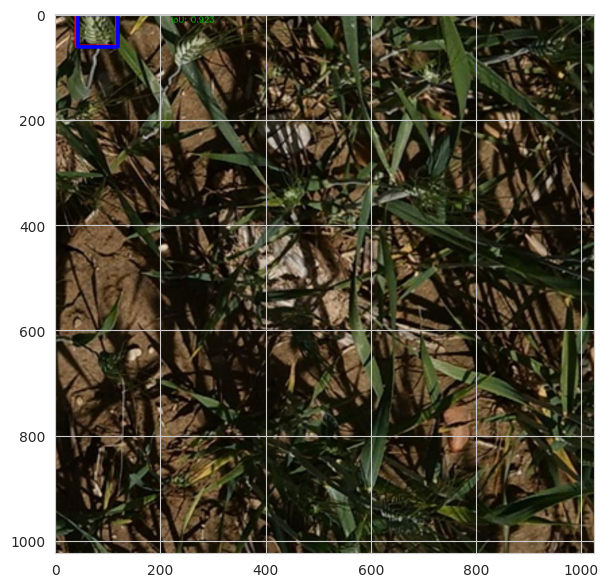

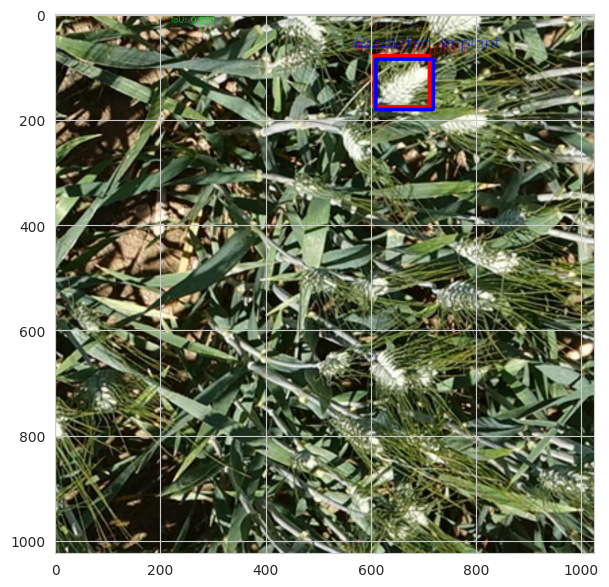

In [ ]:

import random

# indexes = random.sample(range(1, 300), 40)
# indexes.append(test_df['IoU'].argmin())
# indexes.append(test_df['IoU'].argmax())
indexes = test_df[test_df['IoU'] > 0.80].index
print(indexes)

for index in indexes:
  print(index)
  actual_predicted_figure(index)



In [ ]:
  # count TP, FP, FN


num_TP = len(test_df[test_df['0.50']=="TP"])
num_FP = len(test_df[test_df['0.50']=="FP"])
num_FN = len(test_df[test_df['0.50']=="FN"])
num_TN = len(test_df[test_df['0.50']=="TN"])

print("Number of True Positive detections: {}".format(num_TP))
print("Number of False Positive detections: {}".format(num_FP))
print("Number of False Negative detections: {}\n".format(num_FN))

# precision = num_TP/(num_TP + num_FP)

recall = num_TP/(num_TP+num_FN)

# f1_score = 2*(precision*recall/(precision+recall))

# print("Precision: {:.2f}".format(precision))
print("Recall: {}".format(recall))
# print("F1 score: {:.2f}".format(f1_score))

Number of True Positive detections: 7
Number of False Positive detections: 1
Number of False Negative detections: 26

Recall: 0.21212121212121213


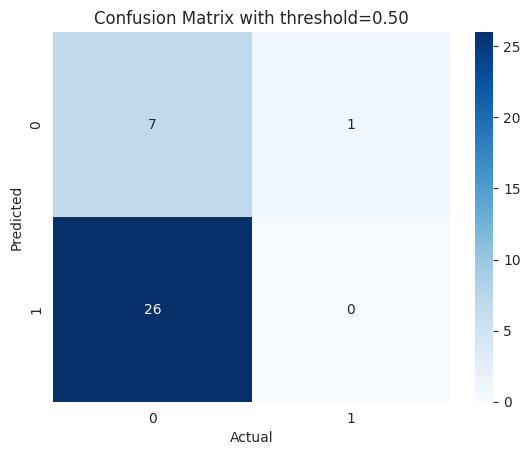

In [ ]:
import seaborn as sns
conf_matrix = [[num_TP, num_FP],[num_FN,num_TN]]

matrix = sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".0f")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix with threshold=0.50")
plt.savefig('CM1')
plt.show()

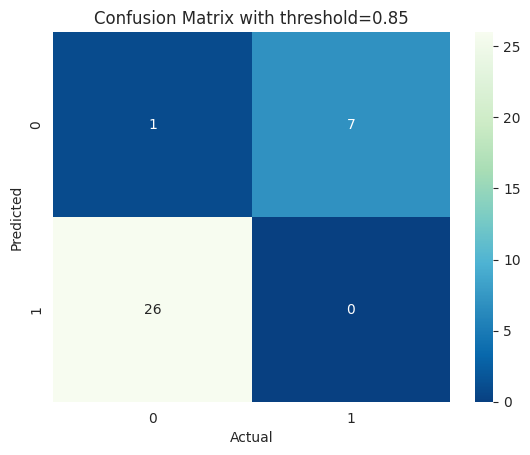

In [ ]:
num_TP = len(test_df[test_df['0.85']=="TP"])
num_FP = len(test_df[test_df['0.85']=="FP"])
num_FN = len(test_df[test_df['0.85']=="FN"])
num_TN = len(test_df[test_df['0.85']=="TN"])

conf_matrix = [[num_TP, num_FP],[num_FN,num_TN]]

matrix = sns.heatmap(conf_matrix, annot=True, cmap="GnBu_r", fmt=".0f")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix with threshold=0.85")
plt.savefig('CM2')
plt.show()

In [ ]:
def precision_recall_calculator(threshold):
  num_TP = len(test_df[test_df[threshold]=="TP"])
  num_FP = len(test_df[test_df[threshold]=="FP"])
  num_FN = len(test_df[test_df[threshold]=="FN"])
  num_TN = len(test_df[test_df[threshold]=="TN"])

  precision = num_TP/(num_TP + num_FP)

  recall = num_TP/(num_TP+num_FN)

  return precision, recall


In [ ]:
precisions = []
recalls = []

for threshold in thresholds:
  threshold = "{:.2f}".format(threshold)
  try: 
  
    precision, recall = precision_recall_calculator(threshold)
    precisions.append(precision)
    recalls.append(recall)

  except ZeroDivisionError:
    precisions.append(0)
    recalls.append(0)
    

print(precisions)
print(recalls)



[1.0, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.625, 0.5, 0.25, 0.125, 0.125, 0.0, 0.0]
[0.23529411764705882, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.21212121212121213, 0.16129032258064516, 0.13333333333333333, 0.07142857142857142, 0.037037037037037035, 0.037037037037037035, 0.0, 0.0]


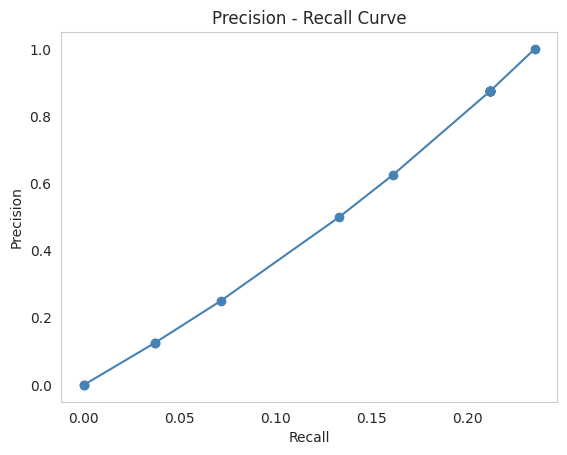

In [ ]:
plt.plot(recalls, precisions,"-o", color='steelblue')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision - Recall Curve")
plt.savefig('RCNN_PR')
plt.grid()
plt.show()

In [ ]:
recalls.append(0.0)
precisions.append(1.0)

recalls_np = np.array(recalls)
precisions_np = np.array(precisions)

In [ ]:
AP = np.sum((recalls_np[:-1] - recalls_np[1:]) * precisions_np[:-1])

print(AP)

0.12930294633330686
